<a href="https://colab.research.google.com/github/Lisankk/Dirisl_Phase2_PJT/blob/minami_branch/%E3%83%A2%E3%83%87%E3%83%AA%E3%83%B3%E3%82%B0%E3%81%9D%E3%81%AE%EF%BC%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# ここからスタート

In [23]:
import pandas as pd
import scipy as sp
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [24]:
#csvファイルの読み込み
df = pd.read_csv("/content/drive/MyDrive/Dirisl-Phase2/data/abtest_results_for_coupon_sending.csv")
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,area_classification,newbie,channel,segment,visit,conversion,spend
0,男性,6,32908,1,1,地方,1,ウェブ,送付なし,0,0,0
1,男性,9,67583,1,0,地方,1,ウェブ,送付あり,0,0,0
2,女性,9,67507,1,1,地方,1,スマートフォン,送付あり,0,0,0
3,男性,2,10164,0,1,都会,0,ウェブ,送付あり,1,0,0
4,女性,4,24142,0,1,地方,1,複数,送付なし,0,0,0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42613 entries, 0 to 42612
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   sex                      42613 non-null  object
 1   recency                  42613 non-null  int64 
 2   history                  42613 non-null  int64 
 3   mens_product_purchase    42613 non-null  int64 
 4   womens_product_purchase  42613 non-null  int64 
 5   area_classification      42613 non-null  object
 6   newbie                   42613 non-null  int64 
 7   channel                  42613 non-null  object
 8   segment                  42613 non-null  object
 9   visit                    42613 non-null  int64 
 10  conversion               42613 non-null  int64 
 11  spend                    42613 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 3.9+ MB


In [26]:
df.describe()

,recency,history,mens_product_purchase,womens_product_purchase,newbie,visit,conversion,spend
count,42613.000000,42613.000000,42613.000000,42613.000000,42613.000000,42613.000000,42613.000000,42613.000000
mean,5.761669,24185.881726,0.552085,0.549527,0.501748,0.472743,0.009129,103.770868
std,3.505422,25657.469003,0.497286,0.497547,0.500003,0.499262,0.095108,1499.644731
min,1.000000,2999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,15700.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,9.000000,32520.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,12.000000,334593.000000,1.000000,1.000000,1.000000,1.000000,1.000000,49900.000000


In [27]:
crossed = pd.crosstab(df["segment"], df["visit"])
crossed

visit,0,1
segment,,
送付あり,7986,13321
送付なし,14482,6824


In [28]:
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)
print(p)

0.0


In [29]:
crossed = pd.crosstab(df["segment"], df["conversion"])
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)
print(p)

2.230841376146663e-13


In [30]:
# どちらも有意差ありだが、visitの方が有意差が大きいのでvisitを目的変数として選択すべき
# 今回の目的はどの顧客にクーポンを配るべきかなので実際に買ってくれたかではなくサイトに訪問したかどうかで判断するとvisitになる

In [31]:
df["sex"] = df["sex"].map({"男性": 0, "女性": 1})
# df["area_classification"] = df["area_classification"].map({"都会": 0, "郊外": 1, "地方": 2})
df["segment"] = df["segment"].map({"送付あり": 0, "送付なし": 1})
# df["channel"] = df["channel"].map({"ウェブ": 0, "スマートフォン": 1, "複数": 2})

In [32]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
encoded = oe.fit_transform(df[['area_classification', 'channel']].values)
encoded = pd.DataFrame(encoded, columns=['encode_area_classification', 'encode_channel'])
df = pd.concat([df, encoded], axis=1)
df = df.drop(['area_classification', 'channel'], axis=1)
df.head()

,sex,recency,history,mens_product_purchase,womens_product_purchase,newbie,segment,visit,conversion,spend,encode_area_classification,encode_channel
0,0,6,32908,1,1,1,1,0,0,0,0.0,0.0
1,0,9,67583,1,0,1,0,0,0,0,0.0,0.0
2,1,9,67507,1,1,1,0,0,0,0,0.0,1.0
3,0,2,10164,0,1,0,0,1,0,0,2.0,0.0
4,1,4,24142,0,1,1,1,0,0,0,0.0,2.0


In [33]:
df

,sex,recency,history,mens_product_purchase,womens_product_purchase,newbie,segment,visit,conversion,spend,encode_area_classification,encode_channel
0,0,6,32908,1,1,1,1,0,0,0,0.0,0.0
1,0,9,67583,1,0,1,0,0,0,0,0.0,0.0
2,1,9,67507,1,1,1,0,0,0,0,0.0,1.0
3,0,2,10164,0,1,0,0,1,0,0,2.0,0.0
4,1,4,24142,0,1,1,1,0,0,0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
42608,0,7,8646,0,1,0,0,1,0,0,2.0,0.0
42609,0,10,10554,1,0,0,0,1,0,0,2.0,0.0
42610,0,5,3890,0,1,1,0,0,0,0,2.0,1.0
42611,0,6,2999,1,0,1,0,1,0,0,2.0,1.0


In [34]:
df.info()#すべての型をint型に整列できた

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42613 entries, 0 to 42612
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sex                         42613 non-null  int64  
 1   recency                     42613 non-null  int64  
 2   history                     42613 non-null  int64  
 3   mens_product_purchase       42613 non-null  int64  
 4   womens_product_purchase     42613 non-null  int64  
 5   newbie                      42613 non-null  int64  
 6   segment                     42613 non-null  int64  
 7   visit                       42613 non-null  int64  
 8   conversion                  42613 non-null  int64  
 9   spend                       42613 non-null  int64  
 10  encode_area_classification  42613 non-null  float64
 11  encode_channel              42613 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 3.9 MB


目的変数のvisitに影響をもたらす変数を説明変数にする。
具体的に選定方法としては、相関係数から見る手法と重回帰分析のp値を見る手法があるが今回は相関係数から判断することにする

<Axes: >

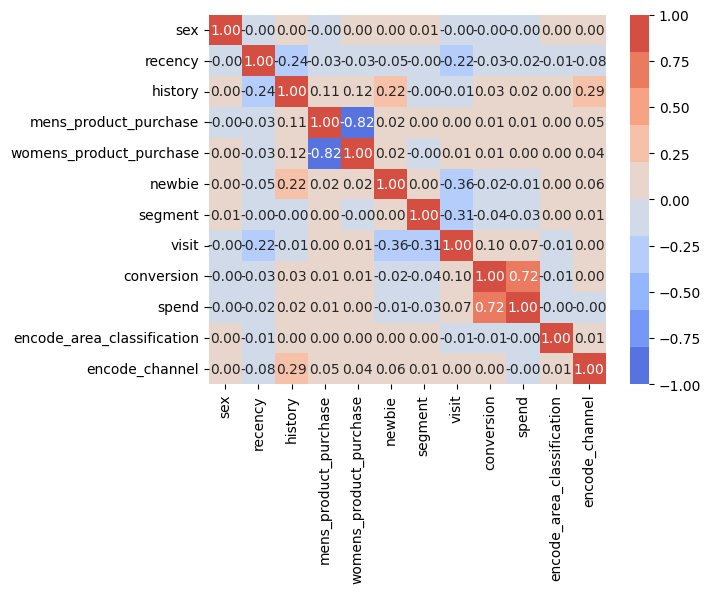

In [35]:
cor = df.corr()
sns.heatmap(cor, cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = -1, vmax = 1)

上図の結果から今回は[recency, history, area_classification, newbie, segment]とする

In [36]:
df_RF = df[["recency", "history", "encode_area_classification", "newbie", "segment", "visit"]]
df_RF

,recency,history,encode_area_classification,newbie,segment,visit
0,6,32908,0.0,1,1,0
1,9,67583,0.0,1,0,0
2,9,67507,0.0,1,0,0
3,2,10164,2.0,0,0,1
4,4,24142,0.0,1,1,0
...,...,...,...,...,...,...
42608,7,8646,2.0,0,0,1
42609,10,10554,2.0,0,0,1
42610,5,3890,2.0,1,0,0
42611,6,2999,2.0,1,0,1


今回はモデルにランダムフォレストを使用しているので特徴量の標準化は不要。
そのまま機械学習に適用する

**多重共線性のチェック**

それぞれの特徴量で相関が強うものがないので多重共線性はないとみて実装を進める

<Axes: >

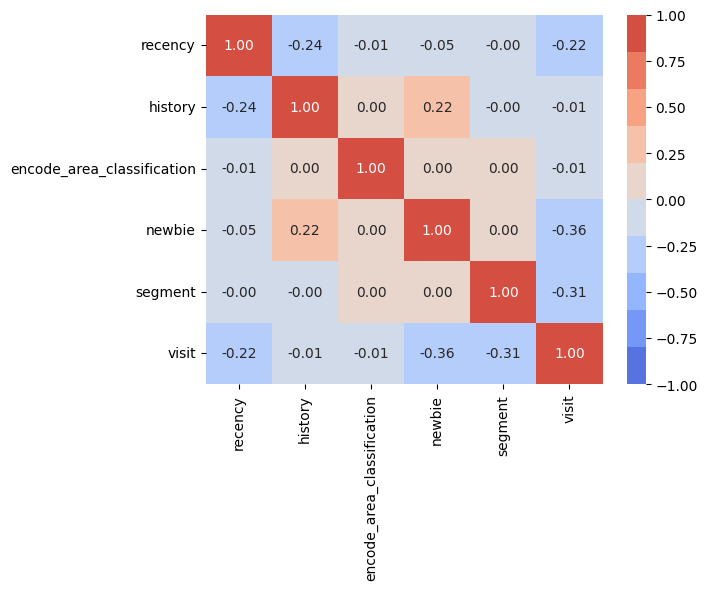

In [37]:
cor = df_RF.corr()
sns.heatmap(cor, cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = -1, vmax = 1)

**データ前処理**

今回の場合はランダムフォレストを使用するので標準化などは行わなくてよい。
前処理は特にせず実装を進める。

**ランダムフォレストの実装に当たってクーポンありとなしのグループに分ける**

In [38]:
df_RF_YesKoupon = df_RF[df_RF["segment"] == 0]
df_RF_NoKoupon = df_RF[df_RF["segment"] == 1]

In [39]:
df_RF_YesKoupon = df_RF_YesKoupon.drop("segment", axis = 1)
df_RF_NoKoupon = df_RF_NoKoupon.drop("segment", axis = 1)

**ランダムフォレストの実装**

In [40]:
x_train, x_test, t_train, t_test = train_test_split(
   df_RF_YesKoupon[["recency", "history", "area_classification", "newbie"]], df_RF_YesKoupon["visit"], test_size=0.3, random_state=0)

print("Train:",len(x_train))
print("Test:", len(x_test))

# 学習モデルを作成
model = RandomForestClassifier()

# 学習モデルにテストデータを与えて学習させる
model.fit(x_train, t_train)

# テストデータを与えて各データの種類を推測
test = model.predict(x_test)

# 正解率
score = accuracy_score(t_test, test)
print(f"正解率：{score * 100}%")

# 適合率
precision = precision_score(t_test, test)
print(f"適合率: {precision * 100}%")

# 再現率
recall = recall_score(t_test, test)
print(f"再現率: {recall * 100}%")

# F値
f1 = f1_score(t_test, test)
print(f"F値: {f1 * 100}%")


KeyError: "['area_classification'] not in index"

In [ ]:
cm = confusion_matrix(t_test, test)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Blues)

In [41]:
test_proba = model.predict_proba(x_test)[:, 1]
pd.DataFrame(test_proba)

,0
0,1.00
1,1.00
2,1.00
3,1.00
4,1.00
...,...
6388,0.30
6389,0.32
6390,1.00
6391,1.00


AUC : 0.92332098486607


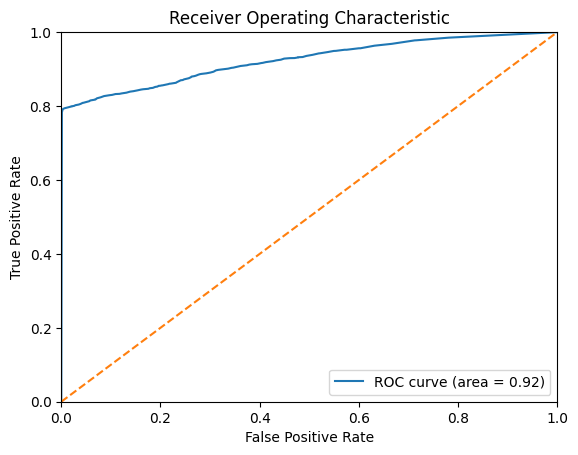

In [42]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

test_auc = roc_auc_score(t_test, test_proba)
print(f'AUC : {test_auc}')
## ROC曲線の描画
fpr, tpr, thresholds = roc_curve(t_test, test_proba)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%roc_auc_score(t_test, test_proba))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
